<a href="https://colab.research.google.com/github/DianaKahar/Data_management3/blob/main/P137263_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**STQD6324 DATA MANAGEMENT**

**INTRODUCTION**

Apache Spark is an open source computing system that provides an intergrated framework fro processing large scale data. Spark offers a wide range of machine learning algorithm and tools designed to scale out data into a cluster. Spark MLlib is a core component of Spark and provides various advantages which include able to handle large dataset by distribution across a cluster (scalibility), able to be ingreted with Sparks other components for data manilulation and analysis, and having extensive functionality that includes broad range of ML algoritms and utilities like extractions, transformation and selection.

**IRIS DATASET INFORMATION**


The iris dataset a.k.a Fishers Iris dataset is a popular dataset found within R environment and usually used in the field of machine learning and statistics. Also commonly used as a benchmark for testing ML algoritms and classification problems. The dataset consist of 150 samples of iris flowers from 3 different species; Iris Setosa, Iris Versicolor and Iris Virginica. Each sample consists of 4 features that describe the physical characteristic of the flower; Sepal Length (cm), Sepal Width (cm), Petal Length (cm) and Petal Width (cm). The dataset also includes the label which indicates the species of each flower. The labels are in numerical values; Iris Setosa (0), Iris Versicolor (1) and Iris Virginica (2). The iris dataset is a best choice for exhibiting classification with Spark MLlib because of its simplicity and structure.

**CLASSIFICATION PROCESS**

1. Import all necessary libraries and install a Spark session.
2. Load the Iris dataset into a Spark Dataframe.
3. Combine the featured columns int vector and encodes the labels.
4. Split the data into training and testing sets.
5. Use Random Forest classifier and set up a parameter grid for hypermeter tuning then use cross validation to find best model.
6. Evaluate the model using accuracy, precision, recall and F1 score metrics.
7. Compare predictiod labels with actual labels and display a confusion matrix.


In [2]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=7d6ae276c1a8f1f294ecf18c730da224e7024fa610a75d56b06b88d10db2dac7
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
import pandas as pd

from sklearn.datasets import load_iris
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
import numpy as np

In [4]:
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['label'] = iris.target

In [5]:
iris_df.to_csv('iris.csv', index=False)

In [6]:
spark = SparkSession.builder.appName("IrisClassification").getOrCreate()

In [7]:
data = spark.read.csv('iris.csv', header=True, inferSchema=True)
data.show()

+-----------------+----------------+-----------------+----------------+-----+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|label|
+-----------------+----------------+-----------------+----------------+-----+
|              5.1|             3.5|              1.4|             0.2|    0|
|              4.9|             3.0|              1.4|             0.2|    0|
|              4.7|             3.2|              1.3|             0.2|    0|
|              4.6|             3.1|              1.5|             0.2|    0|
|              5.0|             3.6|              1.4|             0.2|    0|
|              5.4|             3.9|              1.7|             0.4|    0|
|              4.6|             3.4|              1.4|             0.3|    0|
|              5.0|             3.4|              1.5|             0.2|    0|
|              4.4|             2.9|              1.4|             0.2|    0|
|              4.9|             3.1|              1.5|          

In [8]:
assembler = VectorAssembler(inputCols=iris.feature_names, outputCol="features")
data = assembler.transform(data)

In [9]:
indexer = StringIndexer(inputCol="label", outputCol="indexedLabel")
data = indexer.fit(data).transform(data)
data.show()

+-----------------+----------------+-----------------+----------------+-----+-----------------+------------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|label|         features|indexedLabel|
+-----------------+----------------+-----------------+----------------+-----+-----------------+------------+
|              5.1|             3.5|              1.4|             0.2|    0|[5.1,3.5,1.4,0.2]|         0.0|
|              4.9|             3.0|              1.4|             0.2|    0|[4.9,3.0,1.4,0.2]|         0.0|
|              4.7|             3.2|              1.3|             0.2|    0|[4.7,3.2,1.3,0.2]|         0.0|
|              4.6|             3.1|              1.5|             0.2|    0|[4.6,3.1,1.5,0.2]|         0.0|
|              5.0|             3.6|              1.4|             0.2|    0|[5.0,3.6,1.4,0.2]|         0.0|
|              5.4|             3.9|              1.7|             0.4|    0|[5.4,3.9,1.7,0.4]|         0.0|
|              4.6|

In [10]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

In [11]:
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features")

In [12]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

In [13]:
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="indexedLabel", metricName="accuracy"),
                          numFolds=3)

In [14]:
cvModel = crossval.fit(train_data)

In [15]:
predictions = cvModel.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

In [16]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.972972972972973
Precision: 0.9750519750519752
Recall: 0.972972972972973
F1 Score: 0.972870012870013


From the result shown the classification model performed excellently on the dataset. High values across al matrics suggest that the model can reliably predict the species of iris with a high degress of accuracy, precision, recall and balanced F1 score.

In [17]:
predictions.select("indexedLabel", "prediction").show()


+------------+----------+
|indexedLabel|prediction|
+------------+----------+
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         1.0|       1.0|
|         1.0|       1.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         1.0|       1.0|
|         1.0|       1.0|
|         0.0|       0.0|
|         0.0|       0.0|
|         2.0|       2.0|
|         2.0|       1.0|
+------------+----------+
only showing top 20 rows



The table above provides illustartion of the models performance, showing accuracy with a few missclassifications. From the 20 rows showing, only 1 was missclassified, which shows high accuracy at 97.3%. The misclassification indicates that the model had difficulty in distingushing between virginica and versicolor. Further analysis can be done on the error analysis to gain a deeper understanding and model improve performance.

In [18]:
confusion_matrix = predictions.groupBy("indexedLabel").pivot("prediction").count().fillna(0).orderBy("indexedLabel")
confusion_matrix.show()

+------------+---+---+---+
|indexedLabel|0.0|1.0|2.0|
+------------+---+---+---+
|         0.0| 14|  0|  0|
|         1.0|  0| 12|  0|
|         2.0|  0|  1| 10|
+------------+---+---+---+



From the confusion matrix table we are able to understand that the actual class is within the indexlabel and each column is the predicted class. Iris setosa (0.0) was predicted 14 times correctly, Iris versicolor (1.0) was predicted 12 times correctly, while Iris virginica (2.0) was predicted 10 times correctly and 1 time incorrectly. This indicated only a small error.

In [19]:
best_model = cvModel.bestModel
feature_importances = best_model.featureImportances

In [20]:
features_list = data.columns[:-2]  # Exclude 'features' and 'indexedLabel'
feature_importances_df = pd.DataFrame(list(zip(features_list, feature_importances)),
                                      columns=["Feature", "Importance"]).sort_values(by="Importance", ascending=False)
print(feature_importances_df)

             Feature  Importance
3   petal width (cm)    0.621713
2  petal length (cm)    0.236700
0  sepal length (cm)    0.101994
1   sepal width (cm)    0.039593


The table above shows the feature importance scores for Random Forest classifier. It determines how valuable each feature contributes to reducing the impurity in the decision trees. The more a feature reduces impurity, the more important it is considered. Petal width has the highest important score with 0.621713 which suggest that it is the main classifier for any iris species. The model relies most on this feature to make correct predictions. Petal length is also significant but less important than petal width. Sepal length has a lower feature importance score, however sepal width has the lower importabce score which suggest it has the least amount of impact on the classification decision made by the model.

In [21]:
predictions_pd = predictions.select("indexedLabel", "prediction").toPandas()

In [22]:
print(classification_report(predictions_pd["indexedLabel"], predictions_pd["prediction"]))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        14
         1.0       0.92      1.00      0.96        12
         2.0       1.00      0.91      0.95        11

    accuracy                           0.97        37
   macro avg       0.97      0.97      0.97        37
weighted avg       0.98      0.97      0.97        37



This table shows the classification report for the Random Forest model on the dataset. The model shows high precision and recall for all classes which indicates that it is very effective at indetifying positive instance and minimizing false positives and false negatives. The model has also perfectly classified all instances on Iris setosa and only has a minor misclassification of iris virginica.

**EXTRA INSIGHT**

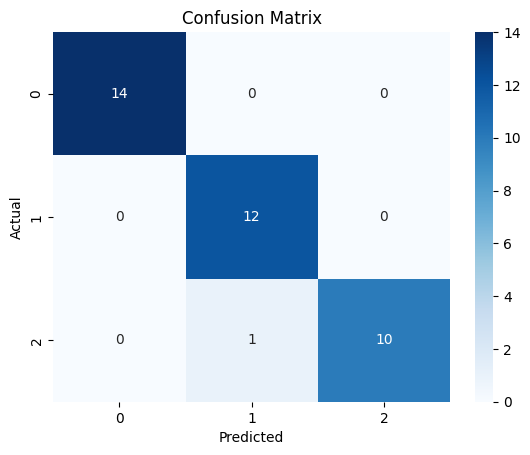

In [23]:
from sklearn.metrics import confusion_matrix # import the function

# rename the DataFrame variable
conf_matrix_df = confusion_matrix(predictions_pd["indexedLabel"], predictions_pd["prediction"])
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

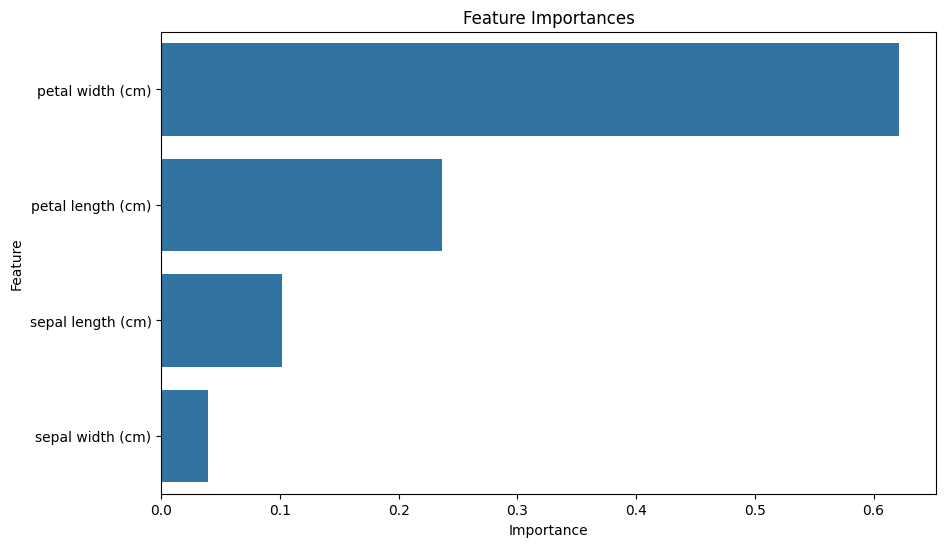

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances_df)
plt.title('Feature Importances')
plt.show()

In [25]:
cv_results = cvModel.avgMetrics
param_maps = cvModel.getEstimatorParamMaps()
param_tuning_df = pd.DataFrame([{**param, "Accuracy": metric} for param, metric in zip(param_maps, cv_results)])
print(param_tuning_df)

   RandomForestClassifier_a12d61499b97__numTrees  \
0                                             10   
1                                             10   
2                                             10   
3                                             20   
4                                             20   
5                                             20   
6                                             30   
7                                             30   
8                                             30   

   RandomForestClassifier_a12d61499b97__maxDepth  Accuracy  
0                                              5  0.931698  
1                                             10  0.931698  
2                                             15  0.931698  
3                                              5  0.924291  
4                                             10  0.924291  
5                                             15  0.924291  
6                                              5  0.

In [26]:
misclassified = predictions_pd[predictions_pd["indexedLabel"] != predictions_pd["prediction"]]
print("Misclassified examples:")
print(misclassified)

Misclassified examples:
    indexedLabel  prediction
19           2.0         1.0


In [27]:
data_pd = data.select(data.columns[:-2] + ["indexedLabel"]).toPandas()
data.show()

+-----------------+----------------+-----------------+----------------+-----+-----------------+------------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|label|         features|indexedLabel|
+-----------------+----------------+-----------------+----------------+-----+-----------------+------------+
|              5.1|             3.5|              1.4|             0.2|    0|[5.1,3.5,1.4,0.2]|         0.0|
|              4.9|             3.0|              1.4|             0.2|    0|[4.9,3.0,1.4,0.2]|         0.0|
|              4.7|             3.2|              1.3|             0.2|    0|[4.7,3.2,1.3,0.2]|         0.0|
|              4.6|             3.1|              1.5|             0.2|    0|[4.6,3.1,1.5,0.2]|         0.0|
|              5.0|             3.6|              1.4|             0.2|    0|[5.0,3.6,1.4,0.2]|         0.0|
|              5.4|             3.9|              1.7|             0.4|    0|[5.4,3.9,1.7,0.4]|         0.0|
|              4.6|

In [28]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve


X = data_pd[features_list]
y = data_pd["indexedLabel"]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Unique values in y:", np.unique(y))

train_sizes, train_scores, valid_scores = learning_curve(
    RandomForestClassifier(), X, y, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

print("Train sizes:", train_sizes)
print("Train scores:", train_scores)
print("Validation scores:", valid_scores)

Shape of X: (150, 5)
Shape of y: (150,)
Unique values in y: [0. 1. 2.]
Train sizes: [ 12  24  36  48  60  72  84  96 108 120]
Train scores: [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Validation scores: [[0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
 [0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]
 [0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]
 [0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]
 [0.96666667 0.96666667 1.         1.         1.        ]
 [1.         1.         0.96666667 1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]]


**CONCLUSION**


From this project we are able to sucessfully perform classification on the Iris dataset using Spark MLlib and Random Forest algorithm. The Random Forest model demonstated high performance and effective classification for the iris species with minimal errors. The petal dimensions (width and lenght) were identified as the most important feature for classification, aligning with biological insights about iris flowers. The model also maintained a balance performance across all classes and indicated reliable predictions. Overall this project demonstrated the effectiveness usuing Spark MLlib and Random Forest for classification tasks, providing valueble insight into importance feature and model performance.